# MoA-net-Small and MoA-net-XSmall

To investigate how class imbalance affects performance, we make subgraphs of MoA-net here in which there are less PPIs.

In [1]:
import pandas as pd
from tqdm import tqdm
import os.path as osp
from copy import deepcopy

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx

# Load enriched KG file

In [2]:
KG_DIR = '../data/kg/'

In [3]:
full_kg = pd.read_csv(osp.join(KG_DIR, 'enriched_kg.tsv'), sep='\t')

Get all of the true drug-BP pairs:

In [4]:
true_pairs = [(row['source'], row['target']) for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()]

Get all of the proteins which go to BPs:

In [5]:
bps_in_pairs = {row['target'] for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()}

prots_to_bps = set()

# get the proteins which interact with those BPs
for i, row in full_kg.loc[(full_kg['edge_type'] == 'participates') & (full_kg['target'].isin(bps_in_pairs))].iterrows():
    prots_to_bps.add((row['source']))

len(prots_to_bps)

3144

Add all of the forward PPIs:

In [6]:
G = nx.DiGraph()

for i, row in full_kg.iterrows():
    if row['edge_type'] == 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G.nodes:
            G.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G.nodes:
            G.add_node(trgt_id, type=row['target_node_type'])
        G.add_edge(src_id, trgt_id, type=row['edge_type'])

G_XS = deepcopy(G)

Here, we subset the PPIs in the graph until they are below the limit. We do this systematically by removing PPIs from high-degree edges.

### MoA-Net-Small

For **MoA-net-Small**, we use a threshhold of 10,000 PPIs.

In [7]:
PPI_LIMIT = 10000

In [8]:
prot_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]
count = 0

while G.number_of_edges() > PPI_LIMIT:
    prot_with_highest_degree = max(prot_nodes, key=lambda n: G.out_degree(n))
    # Find the neighbor of prot_with_highest_degree with the largest degree
    neighbor_of_highest_degree = max([node for node in nx.neighbors(G,prot_with_highest_degree) if node in prot_nodes],
                                      key=lambda n: G.out_degree(n))
    # remove the edge between prot_with_highest_degree and neighbor_of_highest_degree
    G.remove_edge(prot_with_highest_degree, neighbor_of_highest_degree)
    count += 1
    if count % 1000 == 0:
        print(count, G.number_of_edges())

1000 85786
2000 84786
3000 83786
4000 82786
5000 81786
6000 80786
7000 79786
8000 78786
9000 77786
10000 76786
11000 75786
12000 74786
13000 73786
14000 72786
15000 71786
16000 70786
17000 69786
18000 68786
19000 67786
20000 66786
21000 65786
22000 64786
23000 63786
24000 62786
25000 61786
26000 60786
27000 59786
28000 58786
29000 57786
30000 56786
31000 55786
32000 54786
33000 53786
34000 52786
35000 51786
36000 50786
37000 49786
38000 48786
39000 47786
40000 46786
41000 45786
42000 44786
43000 43786
44000 42786
45000 41786
46000 40786
47000 39786
48000 38786
49000 37786
50000 36786
51000 35786
52000 34786
53000 33786
54000 32786
55000 31786
56000 30786
57000 29786
58000 28786
59000 27786
60000 26786
61000 25786
62000 24786
63000 23786
64000 22786
65000 21786
66000 20786
67000 19786
68000 18786
69000 17786
70000 16786
71000 15786
72000 14786
73000 13786
74000 12786
75000 11786
76000 10786


Let's see which proteins are left with a degree of zero:

In [9]:
prots_with_0_degree = [node for node in prot_nodes if G.degree(node) == 0]
len(prots_with_0_degree)

2560

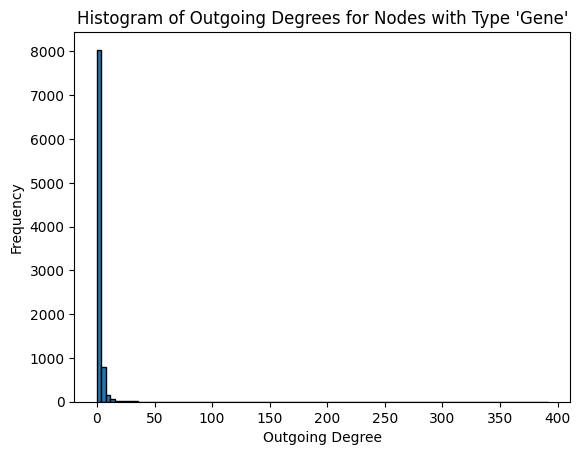

In [10]:
# Filter nodes based on type
prot_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]

# Calculate outgoing degrees of compound nodes
out_degrees = [G.degree(node) for node in prot_nodes]

# Plot histogram
plt.hist(out_degrees, bins=100, range=(0, max(out_degrees) + 0.5), edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Gene'")
plt.show()

In [11]:
degrees = dict(Counter(out_degrees))

for d in sorted(degrees)[0:150]:
    print(d, degrees[d])

0 2560
1 1510
2 2743
3 1227
4 446
5 182
6 107
7 68
8 45
9 41
10 26
11 33
12 13
13 19
14 24
15 7
16 12
17 5
18 3
19 7
20 2
21 6
22 8
24 1
25 2
26 2
27 1
28 5
30 1
31 1
32 2
33 1
34 1
35 2
36 1
38 1
39 1
40 1
42 1
43 3
46 2
49 1
52 1
54 1
62 1
64 1
120 1
183 1
200 1
363 1
391 1


We will remove those isolated nodes.

In [12]:
# remove isolated nodes
def remove_isolated_nodes(G):

    # remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    
    return G

In [13]:
G = remove_isolated_nodes(G)

Add in the other edges:

In [14]:
for i, row in full_kg.iterrows():
    if row['edge_type'] != 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G.nodes:
            G.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G.nodes:
            G.add_node(trgt_id, type=row['target_node_type'])
        G.add_edge(src_id, trgt_id, type=row['edge_type'])

In [15]:
isolated_nodes = list(nx.isolates(G))
len(isolated_nodes)

0

In [16]:
# export G to pandas df with node types
G_df = nx.to_pandas_edgelist(G, edge_key='edge_type')

In [17]:
G_df.rename(columns={'type': 'edge_type'}, inplace=True)

In [18]:
G_df

,source,target,edge_type
0,ncbigene:6622,ncbigene:1861,interacts
1,ncbigene:6622,ncbigene:6477,interacts
2,ncbigene:6622,GO:0043065,participates
3,ncbigene:3308,ncbigene:6767,interacts
4,ncbigene:3308,GO:0006457,participates
...,...,...,...
19703,ncbigene:406928,GO:0043065,participates
19704,ncbigene:440387,GO:0006508,participates
19705,ncbigene:494115,GO:0006397,participates
19706,ncbigene:644672,GO:0007155,participates


In [19]:
def map_to_nodetype(id):
    if 'ncbigene:' in id:
        return 'Gene'
    elif 'GO:' in id:
        return 'Biological Process'
    elif 'pubchem' in id:
        return 'Compound'
    else:
        raise ValueError(f'Unknown node type for {id}')

In [20]:
G_df['source_node_type'] = [map_to_nodetype(i) for i in G_df['source']]
G_df['target_node_type'] = [map_to_nodetype(i) for i in G_df['target']]

In [21]:
Counter(G_df['edge_type'])

Counter({'interacts': 10000,
         'participates': 4288,
         'downregulates': 2178,
         'induces': 1622,
         'upregulates': 1620})

Finally, take out any drug-BP pairs which can no longer be matched:

In [22]:
edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if 'type' in data and data['type'] == 'induces']
G.remove_edges_from(edges_to_remove)

In [23]:
no_path = set()

for pair in true_pairs:
    path_exists = nx.has_path(G, pair[0], pair[1])
    if not path_exists:
        no_path.add(pair)

print(len(no_path))

1165


What proportion of pairs have no path between them?

In [24]:
len(no_path) / len(true_pairs)

0.718249075215783

Drop all of those:

In [25]:
for i, row in G_df.iterrows():
    if row['edge_type'] == 'induces' and (row['source'], row['target']) in no_path:
        G_df.drop(i, inplace=True)

In [26]:
Counter(G_df['edge_type'])

Counter({'interacts': 10000,
         'participates': 4288,
         'downregulates': 2178,
         'upregulates': 1620,
         'induces': 457})

And save the subgraph:

In [27]:
G_df.to_csv(osp.join(KG_DIR, 'small_kg.tsv'), sep='\t', index=False)

### MoA-Net-XSmall

For **MoA-net-XSmall**, we use a threshhold of 12,000 PPIs, then perform a few additional steps.

In [28]:
PPI_LIMIT = 12000

In [29]:
prot_nodes = [node for node, data in G_XS.nodes(data=True) if data["type"] == "Gene"]
count = 0

while G_XS.number_of_edges() > PPI_LIMIT:
    prot_with_highest_degree = max(prot_nodes, key=lambda n: G_XS.out_degree(n))
    # Find the neighbor of prot_with_highest_degree with the largest degree
    neighbor_of_highest_degree = max([node for node in nx.neighbors(G_XS,prot_with_highest_degree) if node in prot_nodes],
                                      key=lambda n: G_XS.out_degree(n))
    # remove the edge between prot_with_highest_degree and neighbor_of_highest_degree
    G_XS.remove_edge(prot_with_highest_degree, neighbor_of_highest_degree)
    count += 1
    if count % 1000 == 0:
        print(count, G_XS.number_of_edges())

1000 85786
2000 84786
3000 83786
4000 82786
5000 81786
6000 80786
7000 79786
8000 78786
9000 77786
10000 76786
11000 75786
12000 74786
13000 73786
14000 72786
15000 71786
16000 70786
17000 69786
18000 68786
19000 67786
20000 66786
21000 65786
22000 64786
23000 63786
24000 62786
25000 61786
26000 60786
27000 59786
28000 58786
29000 57786
30000 56786
31000 55786
32000 54786
33000 53786
34000 52786
35000 51786
36000 50786
37000 49786
38000 48786
39000 47786
40000 46786
41000 45786
42000 44786
43000 43786
44000 42786
45000 41786
46000 40786
47000 39786
48000 38786
49000 37786
50000 36786
51000 35786
52000 34786
53000 33786
54000 32786
55000 31786
56000 30786
57000 29786
58000 28786
59000 27786
60000 26786
61000 25786
62000 24786
63000 23786
64000 22786
65000 21786
66000 20786
67000 19786
68000 18786
69000 17786
70000 16786
71000 15786
72000 14786
73000 13786
74000 12786


Let's see which proteins are left with a degree of zero:

In [30]:
prots_with_0_degree = [node for node in prot_nodes if G_XS.degree(node) == 0]
len(prots_with_0_degree)

2465

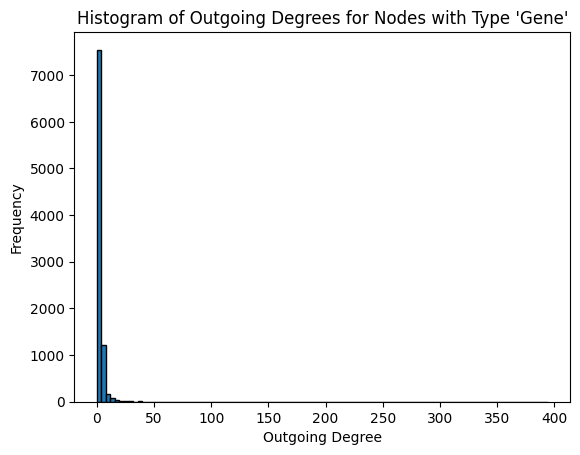

In [31]:
# Filter nodes based on type
prot_nodes = [node for node, data in G_XS.nodes(data=True) if data["type"] == "Gene"]

# Calculate outgoing degrees of compound nodes
out_degrees = [G_XS.degree(node) for node in prot_nodes]

# Plot histogram
plt.hist(out_degrees, bins=100, range=(0, max(out_degrees) + 0.5), edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Gene'")
plt.show()

In [32]:
degrees = dict(Counter(out_degrees))

for d in sorted(degrees)[0:150]:
    print(d, degrees[d])

0 2465
1 1528
2 1208
3 2345
4 649
5 293
6 188
7 96
8 58
9 42
10 33
11 30
12 26
13 23
14 21
15 17
16 15
17 10
18 6
19 8
20 4
21 7
22 8
23 5
24 3
25 3
26 3
27 1
29 3
30 1
31 4
33 2
34 1
35 1
36 6
39 1
40 2
42 1
46 1
48 1
49 2
51 1
52 1
56 1
62 1
73 1
126 1
145 1
196 1
202 1
365 1
391 1
394 1


We will remove those isolated nodes.

In [33]:
G_XS = remove_isolated_nodes(G_XS)

Add in the other edges:

In [34]:
for i, row in full_kg.iterrows():
    if row['edge_type'] != 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G_XS.nodes:
            G_XS.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G_XS.nodes:
            G_XS.add_node(trgt_id, type=row['target_node_type'])
        G_XS.add_edge(src_id, trgt_id, type=row['edge_type'])

In [35]:
isolated_nodes = list(nx.isolates(G_XS))
len(isolated_nodes)

0

Get all the protein nodes which are not connected to a GO BP or drug:

In [36]:
protein_nodes = [node for node, data in G_XS.nodes(data=True) if data.get('type') == 'Gene']

filtered_protein_nodes = set()

for protein_node in protein_nodes:
    neighbors = G_XS.neighbors(protein_node)
    leave_alone = bool(set(neighbors) & prots_to_bps)  # if it has neighbors 
    if leave_alone:
        continue
    
    neighbor_types = [G_XS.nodes[neighbor].get('type') for neighbor in neighbors]
    
    if 'Compound' not in neighbor_types and 'Biological Process' not in neighbor_types:
        filtered_protein_nodes.add(protein_node)

In [37]:
len(filtered_protein_nodes)

3786

Now remove these:

In [38]:
edges_to_remove = []

for edge in G_XS.edges():
    source_node, target_node = edge
    if source_node in filtered_protein_nodes or target_node in filtered_protein_nodes:
        edges_to_remove.append(edge)

G_XS.remove_edges_from(edges_to_remove)

In [39]:
G_XS = remove_isolated_nodes(G)

In [40]:
isolated_nodes = list(nx.isolates(G_XS))
len(isolated_nodes)

0

In [41]:
# export G to pandas df with node types
G_df = nx.to_pandas_edgelist(G_XS, edge_key='edge_type')

In [42]:
G_df.rename(columns={'type': 'edge_type'}, inplace=True)

In [43]:
G_df['source_node_type'] = [map_to_nodetype(i) for i in G_df['source']]
G_df['target_node_type'] = [map_to_nodetype(i) for i in G_df['target']]

In [44]:
Counter(G_df['edge_type'])

Counter({'interacts': 10000,
         'participates': 4288,
         'downregulates': 2178,
         'upregulates': 1620})

Finally, take out any drug-BP pairs which can no longer be matched:

In [45]:
edges_to_remove = [(u, v) for u, v, data in G_XS.edges(data=True) if 'type' in data and data['type'] == 'induces']
G_XS.remove_edges_from(edges_to_remove)

In [46]:
no_path = set()

for pair in true_pairs:
    path_exists = nx.has_path(G_XS, pair[0], pair[1])
    if not path_exists:
        no_path.add(pair)

print(len(no_path))

1165


What proportion of pairs have no path between them?

In [47]:
len(no_path) / len(true_pairs)

0.718249075215783

Drop all of those:

In [48]:
for i, row in G_df.iterrows():
    if row['edge_type'] == 'induces' and (row['source'], row['target']) in no_path:
        G_df.drop(i, inplace=True)

In [49]:
Counter(G_df['edge_type'])

Counter({'interacts': 10000,
         'participates': 4288,
         'downregulates': 2178,
         'upregulates': 1620})

And save the subgraph:

In [50]:
G_df.to_csv(osp.join(KG_DIR, 'xsmall_kg.tsv'), sep='\t', index=False)